## This is the code kindly shared by J. Self, first author of the paper:
#### Self, J.; Bergstrom, H. K. Hypoeutectic Liquid-Solid Phase Diagrams for Ternary Lithium-Ion Battery Electrolytes. Journal of Physical Chemistry Letters 2024, 15 (2), 416-421, Article. DOI: 10.1021/acs.jpclett.3c03169.


In [1]:
# Simplified code for JPCL paper (draft) for Ruihe Li - JS 2024-02-13
import numpy as np, matplotlib.pyplot as plt, pandas as pd, scipy
from scipy import stats,integrate
# Where am I?
#!pwd
#!ls
#
plt.rc('font', size=12)
import pandas

In [2]:
###### 1) global variables ######
#################################
T0EC,T0EMC,R=273.15+38.05,273.15+-53.8,8.31
m_bar_EC,m_bar_EMC=0.088,0.104
HfusEC,HfusEMC=13020,11240 # J/mol (ding) # J/mol (ding)
#### Fitted ####
para_EC_EMC_salt = [2.7936, -7.8747, 1.7636] 
######numerical variables####
nopoints=200000
###### functions #########
def diff_central(a, b):   # self defined function to do differential
    xdc0,xdc1,xdc2 = a[:-2],a[1:-1],a[2:]
    ydc0,ydc1,ydc2 = b[:-2],b[1:-1],b[2:]
    fdc = (xdc2 - xdc1)/(xdc2 - xdc0)
    return (1-fdc)*(ydc2 - ydc1)/(xdc2 - xdc1) + fdc*(ydc1 - ydc0)/(xdc1 - xdc0)
#############

In [3]:
######## 2) Activities of EC ##########################
######################## EC - LiPF6 ###########################
def a32(m_e, para_i_salt ): # Eq. (2)
    [c_i_salt,d_i_salt,e_i_salt,f_i_salt] = para_i_salt
    temp=(
        (1-(2*m_e)/(2*m_e+1/m_bar_EC)) * 
        np.exp(
            c_i_salt*m_e**1.5 + 
            d_i_salt*m_e**2  + 
            e_i_salt*m_e**2.5 + 
            f_i_salt*m_e**3))
    return(temp)
########################### EC - EMC ##########################
def a31(X1,para_i_j): # i=EC, j=EMC     Eq. (3)
    [c_i_j,d_i_j,e_i_j] = para_i_j
    temp=(1-X1)*np.exp(
        c_i_j*X1**2 + 
        d_i_j*X1**3 + 
        e_i_j*X1**4)
    return(temp)

########### 3)  Fitting Activities of EMC ###################
####################### EMC - LiPF6 $########################
plt.figure(1),plt.figure(figsize=(4, 2)) 
def a12(m_e,para_i_salt): # Eq. (2)
    [c_i_salt,d_i_salt,e_i_salt,f_i_salt] = para_i_salt
    temp=(
        (1-(2*m_e)/(2*m_e+1/m_bar_EMC)) *
        np.exp(
            c_i_salt*m_e**1.5 + 
            d_i_salt*m_e**2  + 
            e_i_salt*m_e**2.5 + 
            f_i_salt*m_e**3))
    return(temp)
################################## parametrized ##################################
def a13(X1,para_i_j): # i=EMC j=EC     Eq. (3)
    [c_i_j,d_i_j,e_i_j] = para_i_j
    temp=(1-X1)*np.exp(
        c_i_j*X1**2  +  
        d_i_j*X1**3  + 
        e_i_j*X1**4   ) #three suffix Margules
    return(temp)

<Figure size 640x480 with 0 Axes>

<Figure size 400x200 with 0 Axes>

In [4]:
################################################################
########### 4) Establishing mixing rules #######################
################################################################
########### binary global parameters ###########################
para_EC_EMC  = [-0.66992, 4.2840,   -2.5671,   ]
para_EMC_EC  = [0.62190, 2.5617,   -2.5672,    ]
para_EC_salt = [0.042895, -0.38832, 0.0663, -0.017291]

para_EMC_salt = [0.82629, -1.7913, 1.7011, -0.63441]

###############   Eq. (7)  #############################
def Fun_a_EC_simplified(m_e,X_EMC,para_i_j_salt,X3=0,alpha=0): # aEC 
    [c_i_j_salt,d_i_j_salt,e_i_j_salt] = para_i_j_salt
    X_EMC_apo=X_EMC/(X_EMC+X_EMC*alpha)
    X_EC_apo=X_EMC*alpha
    # X2=1-X_EMC-X_EC_apo
    first_term  =X_EC_apo
    second_term =a32(m_e,para_EC_salt)/(1-(2*m_e)/(2*m_e+1/m_bar_EC))
    third_term  =a31(X_EMC_apo,para_EC_EMC) / (1-X_EMC_apo)
    fourth_term =np.exp(
        c_i_j_salt*m_e**1.5*X_EMC_apo**2 + 
        d_i_j_salt*m_e**1.5*X_EMC_apo**3 + 
        e_i_j_salt*m_e**2*X_EMC_apo**2  )
    ai_tern = first_term*second_term*third_term*fourth_term
    return(ai_tern)#
def Fun_a_EMC_simplified(m_e,X_EC,alpha=0): # aEMC 
    # X_EMC_apo=X_EC*alpha/(X_EC*alpha+X_EC) # Self version
    X_EC_apo=X_EC/(X_EC*alpha+X_EC)   # actually it is X_EC_apo
    # X_EMC_apo=X_EC/(alpha+1E-16)/(X_EC*alpha+X_EC)
    X_EMC =X_EC/(alpha+1E-16)
    # X2=1-X3-X1test
    first_term=X_EMC
    second_term = a13(X_EC_apo,para_EMC_EC)/(1-X_EC_apo) 
    third_term  = a12(m_e,para_EMC_salt) / (
        1-  (2*m_e)/(2*m_e+1/m_bar_EMC))
    ai_tern = first_term*second_term*third_term
    return(ai_tern)

In [5]:
# alpha is the mole ratio between EC:EMC  -> m_EC/m_EMC = alpha

In [6]:
####  TD Factor function (eq 10) ####
def calculatedTDfactor(alpha=1):
    nopoints=100000
    xLiTest=np.linspace(0,0.1,nopoints)
    mEC=1/(m_bar_EC+m_bar_EMC/alpha)
    mEMC=mEC/alpha
    mLiTest=(mEC+mEMC)*xLiTest/(1-2*xLiTest) # mEC+mEMC
    X_EMC=mEMC/(mEMC+mEC+2*mLiTest)
    X_EC=mEC/(mEC+mEMC+2*mLiTest)
    aEC=Fun_a_EC_simplified(mLiTest,X_EMC,para_EC_EMC_salt,alpha=alpha)
    aEMC=Fun_a_EMC_simplified(mLiTest,X_EC,alpha=alpha)
    tempGD = (
        - 0.5* mEMC * np.log(aEMC[:] / aEMC[0]) 
        - 0.5* mEC  * np.log(aEC[:]  / aEC[0] ) 
        )
    calculatedTDfactorRETURN=diff_central(mLiTest[4:],tempGD[:-4])
    return(mLiTest[2+4:],calculatedTDfactorRETURN,aEMC)
x11,yTDF11,aEMC11=calculatedTDfactor(alpha=1.18)
x10,yTDF10,aEMC10=calculatedTDfactor(alpha=1e4)
x01,yTDF01,aEMC01=calculatedTDfactor(alpha=1e-4)

In [7]:
# yTDF01
#aEMC01
aEMC11

array([0.59757905, 0.59757787, 0.59757671, ..., 0.51773441, 0.51773171,
       0.51772902])

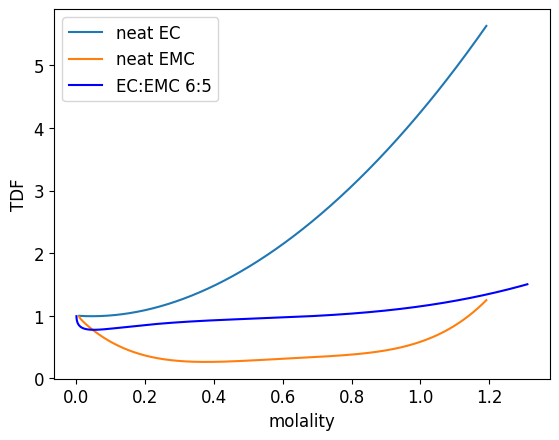

In [8]:
plt.plot(np.sqrt(x10),yTDF10,label="neat EC")
plt.plot(np.sqrt(x10),yTDF01,label="neat EMC")
plt.plot(x11,yTDF11,'b',label="EC:EMC 6:5")
plt.xlabel("molality")
plt.ylabel("TDF")
plt.legend()